In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from utils import get_logicals
import stim
from scipy.sparse import lil_matrix
from tqdm import tqdm
from ldpc import bposd_decoder, bp_decoder
from scipy.optimize import curve_fit
# %load_ext snakeviz

In [36]:
GF = galois.GF(2)
ccode = read_code("./codes/ccodes/8_6_3_4.code")
H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1
dim0, dim1 = H.shape
print(H)
print(dim1 - np.linalg.matrix_rank(GF(H)))

[[0 1 1 1 0 0 1 0]
 [0 1 1 0 1 0 0 1]
 [1 0 0 0 1 1 1 0]
 [1 0 1 0 0 1 0 1]
 [1 0 0 1 0 0 1 1]
 [0 1 0 1 1 1 0 0]]
2


(48, 100)


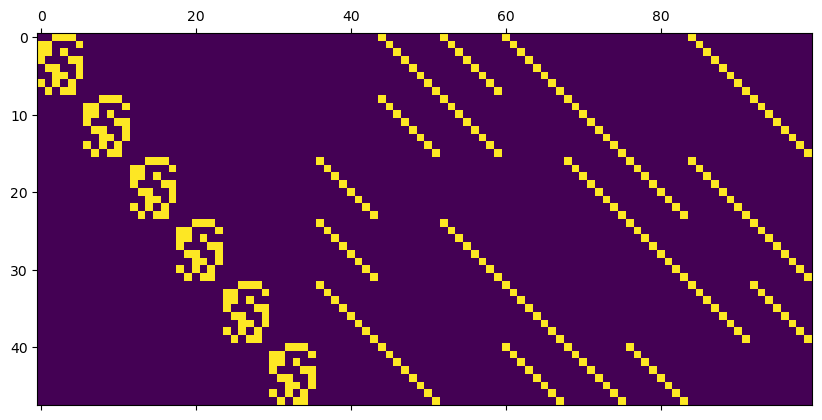

In [37]:
I1 = np.eye(dim1, dtype=int)
I0 = np.eye(dim0, dtype=int)

dE21 = np.kron(H, I0)
dE22 = np.kron(I1, H.T)
dE2 = np.vstack([dE21, dE22])
Hz = dE2.T

dE11 = np.kron(I0, H.T)
dE12 = np.kron(H, I1)
dE1 = np.hstack([dE11, dE12])
Hx = dE1

print(Hz.shape)
plt.matshow(Hx)

In [38]:
zL = get_logicals(Hx, Hz, False)
xL = get_logicals(Hx, Hz, True)
print(len(zL))

4


In [39]:
# iceberg642Xlogicals = np.array([
#     [0,1],
#     [0,2],
#     [0,3],
#     [0,4],
# ])

# iceberg642Zlogicals = np.array([
#     [1,5],
#     [2,5],
#     [3,5],
#     [4,5]
# ])

iceberg642Xlogicals = np.array([
    [1,2],
    [0,1],
    [4,5],
    [3,4],
])

iceberg642Zlogicals = np.array([
    [0,1],
    [1,2],
    [3,4],
    [4,5]
])


iceberg422Xlogicals = np.array([
    [0,1],
    [0,2]
])

iceberg422Zlogicals = np.array([
    [1,3],
    [2,3]
])

(50, 200)


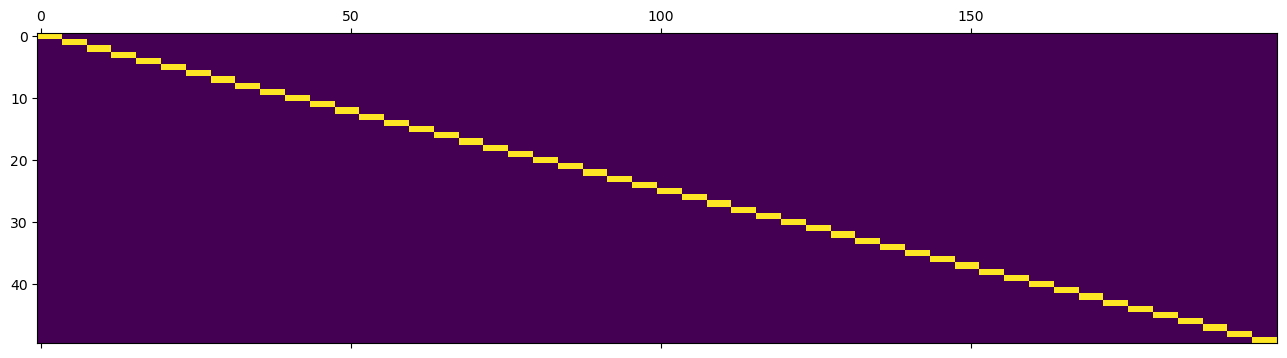

In [40]:
n = 4
k = n-2
icebergX = np.ones(n, dtype=int)
icebergZ = np.ones(n, dtype=int)
icebergXlogicals = iceberg422Xlogicals if n == 4 else iceberg642Xlogicals
icebergZlogicals = iceberg422Zlogicals if n == 4 else iceberg642Zlogicals

concatenatedStabilizersQED = np.kron(np.eye(int(np.ceil(Hx.shape[1]/(n-2))), dtype=int), icebergX)
print(concatenatedStabilizersQED.shape)
plt.matshow(concatenatedStabilizersQED)

In [41]:
concatenatedStabilizersXQEC = np.zeros(shape=(Hx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedStabilizersZQEC = np.zeros(shape=(Hz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Hx):
    for x in np.where(r)[0]:
        concatenatedStabilizersXQEC[i][icebergXlogicals[x%k]+(n*(x//k))] ^= 1
        # print(x, x%4, x//4, "|", icebergXlogicals[x%k]+(n*(x//k))) # x%4 decides which logical, x//4 decides which block
    # print()

for i, r in enumerate(Hz):
    for z in np.where(r)[0]:
        concatenatedStabilizersZQEC[i][icebergZlogicals[z%k]+(n*(z//k))] ^= 1
    #     print(z, z%4, z//4, "|", icebergZlogicals[z%k]+(n*(z//k)))
    # print()

concatenatedHx = np.vstack([concatenatedStabilizersXQEC, concatenatedStabilizersQED][::-1])
concatenatedHz = np.vstack([concatenatedStabilizersZQEC, concatenatedStabilizersQED][::-1])

In [42]:
concatenatedHx.shape[1] - np.linalg.matrix_rank(GF(concatenatedHx)) - np.linalg.matrix_rank(GF(concatenatedHz))

4

(98, 200)


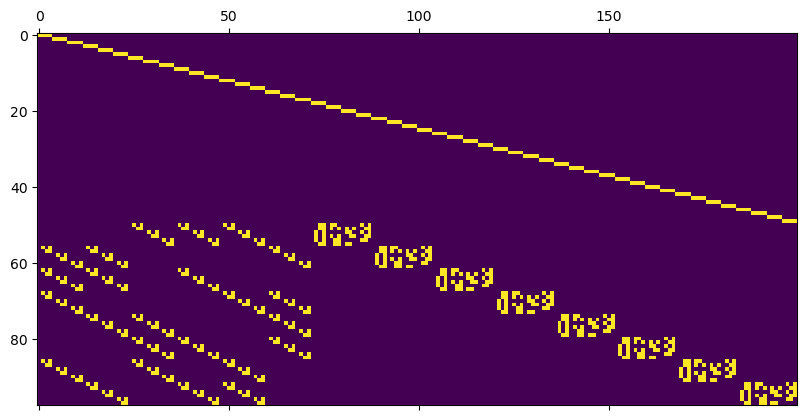

In [43]:
print(concatenatedHx.shape)
plt.matshow(concatenatedHz)

In [50]:
np.savetxt("codes/Hz.txt", concatenatedHz, fmt="%d")
np.savetxt("codes/Hx.txt", concatenatedHx, fmt="%d")

In [54]:
concatenatedxL = np.zeros(shape=(zL.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedzL = np.zeros(shape=(xL.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(xL):
    for x in np.where(r)[0]:
        concatenatedxL[i][icebergXlogicals[x%k]+(n*(x//k))] ^= 1
        # print(x, x%4, x//4, "|", icebergXlogicals[x%k]+(n*(x//k))) # x%4 decides which logical, x//4 decides which block
    # print()

for i, r in enumerate(zL):
    for z in np.where(r)[0]:
        concatenatedzL[i][icebergZlogicals[z%k]+(n*(z//k))] ^= 1
    #     print(z, z%4, z//4, "|", icebergZlogicals[z%k]+(n*(z//k)))
    # print()
xL_inds = [np.where(x)[0] for x in concatenatedxL]
zL_inds = [np.where(z)[0] for z in concatenatedzL]

In [56]:
concatenatedzL = get_logicals(concatenatedHx, concatenatedHz, False)
concatenatedxL = get_logicals(concatenatedHx, concatenatedHz, True)
print(len(concatenatedxL))

12


In [9]:
for l in concatenatedxL:
    print(np.where(l))

(array([ 18,  20,  24,  25,  30,  31,  34,  35,  40,  41,  45,  47,  51,
        52,  84,  85,  88,  89,  94,  95, 111, 112, 115, 116, 121, 122,
       138, 139, 141, 143, 147, 149, 175, 176], dtype=int64),)
(array([ 19,  20,  21,  22,  25,  26,  30,  31,  36,  38,  46,  47,  48,
        49,  52,  53,  84,  85,  90,  92, 111, 112, 117, 119, 141, 143,
       148, 149, 150, 152, 172, 173], dtype=int64),)
(array([ 16,  17,  21,  23,  25,  26,  27,  28,  33,  34,  36,  38,  43,
        44,  48,  50,  52,  53,  81,  82,  87,  88,  90,  92, 108, 109,
       114, 115, 117, 119, 144, 146, 150, 152, 171, 173], dtype=int64),)
(array([174, 175, 177, 179, 183, 185, 193, 194], dtype=int64),)
(array([177, 179, 184, 185, 186, 188, 190, 191], dtype=int64),)
(array([180, 182, 186, 188, 189, 191], dtype=int64),)
(array([120, 121, 123, 125, 129, 131, 139, 140], dtype=int64),)
(array([123, 125, 130, 131, 132, 134, 136, 137], dtype=int64),)
(array([126, 128, 132, 134, 135, 137], dtype=int64),)


In [10]:
for l in concatenatedzL:
    print(np.where(l)[0])

[139 140 157 158 211 212 247 248 265 266 283 284]
[139 140 141 142 157 158 159 160 211 212 213 214 247 248 249 250 265 266
 267 268 283 284 285 286]
[144 145 162 163 216 217 252 253 270 271 288 289]
[175 176 193 194 247 248 265 266 283 284 301 302]
[175 176 177 178 193 194 195 196 247 248 249 250 265 266 267 268 283 284
 285 286 301 302 303 304]
[180 181 198 199 252 253 270 271 288 289 306 307]
[121 122 229 230 247 248 265 266 283 284 319 320]
[121 122 123 124 229 230 231 232 247 248 249 250 265 266 267 268 283 284
 285 286 319 320 321 322]
[126 127 234 235 252 253 270 271 288 289 324 325]


(165, 342)


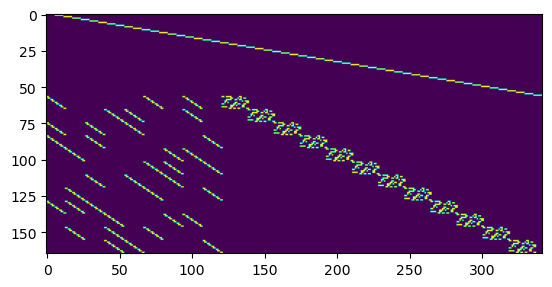

In [11]:
print(concatenatedHx.shape)
plt.imshow(concatenatedHz)

In [12]:
overlapping_x_generators = np.empty(concatenatedStabilizersQED.shape[0], dtype=object)
for i in range(concatenatedStabilizersQED.shape[0]):
    tmp = np.array([], dtype=int)
    for j in range(concatenatedStabilizersXQEC.shape[0]):
        if np.any(concatenatedStabilizersQED[i] & concatenatedStabilizersXQEC[j]): tmp = np.append(tmp, j+concatenatedStabilizersQED.shape[0])
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(concatenatedStabilizersQED.shape[0], dtype=object)
for i in range(concatenatedStabilizersQED.shape[0]):
    tmp = np.array([], dtype=int)
    for j in range(concatenatedStabilizersZQEC.shape[0]):
        if np.any(concatenatedStabilizersQED[i] & concatenatedStabilizersZQEC[j]): tmp = np.append(tmp, j+concatenatedStabilizersQED.shape[0])
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])
    return list(gens_to_measure)

In [13]:
def to_mtx(H):
    print("%%MatrixMarket matrix coordinate integer general\n")
    print(f"{H.shape[0]} {H.shape[1]} {np.count_nonzero(H)}")

    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if H[i][j]:
                print(f"{i+1} {j+1} 1")
# to_mtx(concatenatedHx)

In [14]:
cm, cn = concatenatedHx.shape
qedm, qedn = concatenatedStabilizersQED.shape
qecm, qecn = concatenatedStabilizersXQEC.shape
data_qbts = np.arange(cn)
x_checks = np.arange(cn,cn+cm)
z_checks = np.arange(cn+cm,cn+cm+cm)
all_qbts = np.arange(cn+cm+cm)

precomputed_x_checks_circuits = np.empty(cm, dtype=object)
for x in np.arange(cm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(concatenatedHx[x])[0]]
    for qbt in gen_qbts:
        path_qbts = [x_checks[x], qbt]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, 1e-4)
    precomputed_x_checks_circuits[x] = c

def prepare_x_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-6)
    for x in checks:
        c += precomputed_x_checks_circuits[x]
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-6)
    return c

precomputed_z_checks_circuits = np.empty(cm, dtype=object)
for z in np.arange(cm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(concatenatedHz[z])[0]]
    for qbt in gen_qbts:
        path_qbts = [qbt, z_checks[z]]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, 1e-4)
    precomputed_z_checks_circuits[z] = c

def prepare_z_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for z in checks:
        c += precomputed_z_checks_circuits[z]
    return c

In [15]:
class Simulation:
    def __init__(self, num_rounds, stab_type, adaptive=True):
        self.num_rounds = num_rounds
        self.stab_type = stab_type
        self.curr_round = 1
        self.adaptive = adaptive

        self.prev_meas_z = np.zeros(cm, dtype=int)
        self.prev_meas_x = np.zeros(cm, dtype=int)
        self.curr_meas_z = np.zeros(cm, dtype=int)
        self.curr_meas_x = np.zeros(cm, dtype=int)

        self.confirmation_z = np.ones(cm, dtype=int)
        self.confirmation_x = np.ones(cm, dtype=int)
        self.z_check_history = np.ones(cm, dtype=int)
        self.x_check_history = np.ones(cm, dtype=int)
        self.z_syndrome_history = np.zeros(shape=(num_rounds+1, cm), dtype=int)
        self.x_syndrome_history = np.zeros(shape=(num_rounds+1, cm), dtype=int)

        self.c = stim.Circuit()
        self.c.append("M", 0) # hacky way to make detectors that aren't affected by anything
        self.s = stim.TableauSimulator()

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(cm)).without_noise()
            # self.c.append("X_ERROR", z_checks, 1e-4)
            for i, z_check in enumerate(np.arange(cm)):
                self.c.append("MR", z_checks[z_check])
                self.prev_meas_z[z_check] = self.c.num_measurements
            # self.c.append("X_ERROR", z_checks, 1e-5)
        else:
            self.c += prepare_x_checks(np.arange(cm)).without_noise()
            # self.c.append("X_ERROR", x_checks, 1e-4)
            for i, x_check in enumerate(np.arange(cm)):
                self.c.append("MR", x_checks[x_check])
                self.prev_meas_x[x_check] = self.c.num_measurements
            # self.c.append("X_ERROR", x_checks, 1e-5)

        self.s.do_circuit(self.c)
        if self.stab_type:
            self.z_syndrome_history[0] = self.s.current_measurement_record()[1:]
        else:
            self.x_syndrome_history[0] = self.s.current_measurement_record()[1:]


    def detectors(self, stab_type):
        num_meas = self.c.num_measurements
        prev_meas = self.prev_meas_x if stab_type else self.prev_meas_z
        curr_meas = self.curr_meas_x if stab_type else self.curr_meas_z

        for i, check in enumerate(np.arange(cm)):
            if not prev_meas[i]:
                self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1)] if curr_meas[i] else [stim.target_rec(-num_meas)], (i,self.curr_round))
            else:
                self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1), stim.target_rec(prev_meas[i]-num_meas-1)] if curr_meas[i] else [stim.target_rec(-num_meas)], (i,self.curr_round))
            if curr_meas[i]:
                prev_meas[i] = curr_meas[i]
                curr_meas[i] = 0

        if stab_type:
            self.prev_meas_x = prev_meas
            self.curr_meas_x = curr_meas
        else:
            self.prev_meas_z = prev_meas
            self.curr_meas_z = curr_meas

    def final_detectors_and_observables(self, stab_type):
        c = stim.Circuit()

        if self.stab_type: self.c.append("H", [qbt for qbt in data_qbts])
        # self.c.append("X_ERROR", [qbt for qbt in data_qbts], 1e-4)
        c.append("M", data_qbts)

        num_meas = self.c.num_measurements + c.num_measurements
        H = concatenatedHx if stab_type else concatenatedHz
        prev_meas = self.prev_meas_x if stab_type else self.prev_meas_z
        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = [j-cn for j in incl_qbts]
            target_recs = [stim.target_rec(j) for j in incl_qbts]

            if prev_meas[i]:
                target_recs.append(stim.target_rec(prev_meas[i]-num_meas-1))
            c.append("DETECTOR", target_recs, (i, self.curr_round))


        for i, logical in enumerate(concatenatedxL if stab_type else concatenatedzL):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-cn for j in incl_qbts]
            c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)
        return c

    def QED(self):
        def measure_z_qed_checks(c):
            c += prepare_z_checks(np.arange(qedm))
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qedm)], 1e-4)
            for i, z_check in enumerate(np.arange(qedm)):
                c.append("MR", z_checks[z_check])
                self.curr_meas_z[z_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qedm)], 1e-5)
            return c

        def measure_x_qed_checks(c):
            c += prepare_x_checks(np.arange(qedm))
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qedm)], 1e-4)
            for i, x_check in enumerate(np.arange(qedm)):
                c.append("MR", x_checks[x_check])
                self.curr_meas_x[x_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qedm)], 1e-5)
            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qed_checks(c).without_noise()
            c = measure_z_qed_checks(c).without_noise()
        else:
            c = measure_z_qed_checks(c).without_noise()
            c = measure_x_qed_checks(c).without_noise()
        return c

    def QEC(self):
        def measure_z_qec_checks(c, curr_z_checks):
            c += prepare_z_checks(curr_z_checks)
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], 1e-4)
            for i, z_check in enumerate(curr_z_checks):
                c.append("MR", z_checks[z_check])
                self.curr_meas_z[z_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", z_checks, 1e-5)
            return c

        def measure_x_qec_checks(c, curr_x_checks):
            c += prepare_x_checks(curr_x_checks)
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], 1e-4)
            for i, x_check in enumerate(curr_x_checks):
                c.append("MR", x_checks[x_check])
                self.curr_meas_x[x_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", x_checks, 1e-5)
            return c

        curr_z_checks = np.arange(qedm, cm)[self.confirmation_z[qedm:]==1]
        curr_x_checks = np.arange(qedm, cm)[self.confirmation_x[qedm:]==1]

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qec_checks(c, curr_x_checks).without_noise()
            c = measure_z_qec_checks(c, curr_z_checks).without_noise()
        else:
            c = measure_z_qec_checks(c, curr_z_checks).without_noise()
            c = measure_x_qec_checks(c, curr_x_checks).without_noise()
        return c

    def simulate(self):

        for i in range(1, self.num_rounds+1):
            self.c.append("X_ERROR", data_qbts, 0.01)  # idle errors
            self.s.x_error(*data_qbts, p=0.01)

            self.z_syndrome_history[i] = self.z_syndrome_history[i-1]
            self.x_syndrome_history[i] = self.x_syndrome_history[i-1]

            QED_circuit = self.QED()
            self.s.do_circuit(QED_circuit)
            self.c += QED_circuit

            # determining which of the QEC stabilizers to measure
            meas = self.s.current_measurement_record()
            self.z_syndrome_history[i][:qedm] = meas[-(2*qedm):-qedm]
            self.x_syndrome_history[i][:qedm] = meas[-qedm:]

            z_qed_synd_diff = self.z_syndrome_history[i-1][:qedm] ^ self.z_syndrome_history[i][:qedm]
            x_qed_synd_diff = self.x_syndrome_history[i-1][:qedm] ^ self.x_syndrome_history[i][:qedm]

            curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))
            curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))
            # print(i, np.where(z_qed_synd_diff)[0], curr_z_checks)
            # print(curr_x_checks)

            if self.adaptive:
                self.confirmation_z = np.array([1 if ((z < qedm) or (z in curr_z_checks)) else 0 for z in np.arange(cm)])
                self.confirmation_x = np.array([1 if ((x < qedm) or (z in curr_x_checks)) else 0 for x in np.arange(cm)])
            else:
                self.confirmation_z = np.ones(cm, dtype=int)
                self.confirmation_x = np.ones(cm, dtype=int)
            self.z_check_history = np.vstack([self.z_check_history, self.confirmation_z])
            self.x_check_history = np.vstack([self.x_check_history, self.confirmation_x])

            QEC_circuit = self.QEC()
            self.s.do_circuit(QEC_circuit)
            self.c += QEC_circuit

            meas = self.s.current_measurement_record()
            lookback = lambda x: -len(x) if len(x) else None
            if len(curr_z_checks): self.z_syndrome_history[i][curr_z_checks] = meas[lookback(curr_z_checks+curr_x_checks):lookback(curr_x_checks)]
            if len(curr_x_checks): self.x_syndrome_history[i][curr_x_checks] = meas[lookback(curr_x_checks):]

            self.detectors(self.stab_type)
            self.curr_round += 1

        obs_circuit = self.final_detectors_and_observables(self.stab_type)
        self.s.do_circuit(obs_circuit)
        self.c += obs_circuit

In [16]:
s = Simulation(10, False, adaptive=False)
s.simulate()
c = s.c

In [17]:
sampler = c.compile_detector_sampler()
dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.bool_)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.bool_)

errors = []
channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=100, #pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=min(pcm.shape[0],10) #the osd search depth
)

successes = 0
for ii in tqdm(range(1000)):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    guessed_errors = bposd_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2
    success = np.all(observable_flips[0].astype(int) == guessed_obs)
    successes += success

successes

(1815, 3380)
(9, 3380)


100%|██████████| 1000/1000 [00:38<00:00, 25.96it/s]


577

In [227]:
rounds, gens = np.where(s.z_check_history == 0)
unused_checks = np.array([r*g for r,g in zip(rounds, gens)])
unused_checks

array([], dtype=float64)

In [228]:
 # building and decoding circuit-level Tanner graph
dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=int)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=int)

channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    _dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    _obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[_dets],i] = 1
    lcm[[_obs],i] = 1

bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=100, #concatenatedHz.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=min(Hz.shape[0],10) #the osd search depth
)

In [229]:
np.where(pcm.getnnz(axis=0) == 0)

(array([9468, 9469], dtype=int64),)

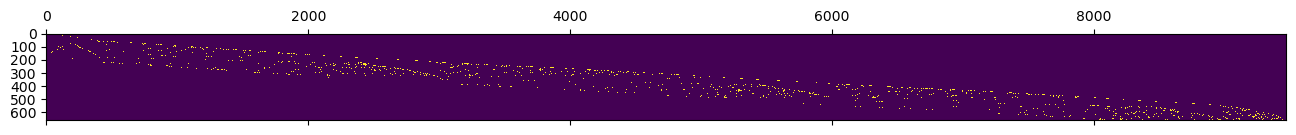

In [230]:
plt.matshow(pcm.A)

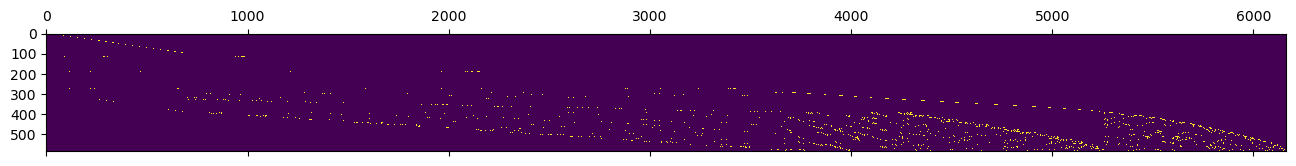

In [143]:
plt.matshow(pcm.A)

In [232]:
num_iters = 1000
successes = 0

for i in tqdm(range(num_iters)):
    s = Simulation(3, False, adaptive=True)
    s.simulate()
    c = s.c

    data_qbts_meas = np.array(s.s.current_measurement_record()[-cn:])
    observable = []
    for l in zL_inds:
        qbts = data_qbts_meas[l]
        observable.append(np.count_nonzero(qbts) % 2)

    final_synd = []
    for j in range(concatenatedHz.shape[0]):
        qbts = data_qbts_meas[np.where(concatenatedHz[j])[0]]
        final_synd.append(np.count_nonzero(qbts) % 2)
    s.z_syndrome_history = np.vstack([s.z_syndrome_history, final_synd])
    # final_synd = []
    # for j in range(concatenatedHx.shape[0]):
    #     qbts = data_qbts_meas[np.where(concatenatedHx[j])[0]]
    #     final_synd.append(np.count_nonzero(qbts) % 2)
    # s.x_syndrome_history = np.vstack([s.x_syndrome_history, final_synd])

    dets = np.zeros((len(s.z_syndrome_history)-1, cm), dtype=int)
    for i in range(dets.shape[0]):
        dets[i] = s.z_syndrome_history[i] ^ s.z_syndrome_history[i+1]
    dets = dets.flatten()

     # building and decoding circuit-level Tanner graph
    # dem = c.detector_error_model()
    # pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=int)
    # lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=int)

    # channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
    # for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    #     _dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    #     _obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    #     pcm[[_dets],i] = 1
    #     lcm[[_obs],i] = 1


    # bposd_dec = bposd_decoder(
    #     pcm, # the parity check matrix
    #     channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    #     max_iter=100, #concatenatedHz.shape[1], #the maximum number of iterations for BP)
    #     bp_method="ms",
    #     ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    #     osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    #     # osd_order=min(Hz.shape[0],10) #the osd search depth
    # )

    guess = bposd_dec.decode(dets)
    success = np.all(((lcm @ guess) % 2) == observable)
    successes += success
print(successes)

100%|██████████| 1000/1000 [00:48<00:00, 20.47it/s]

975


In [ ]:
# 55 vs 971 vs 983

Text(0, 0.5, 'Logical error rate')

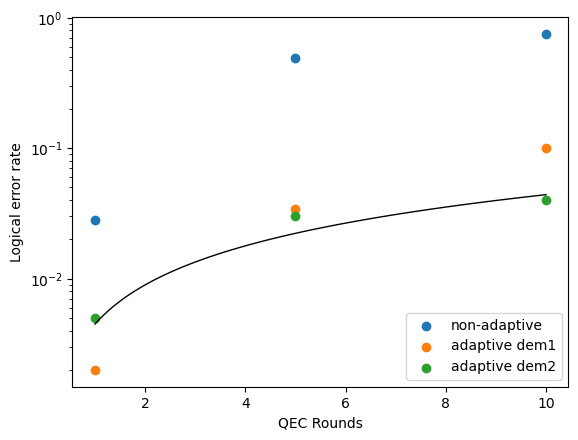

In [64]:
x = [1,5,10]

ynoad = [1-972/1000, 1-51/100, 1-25/100]
yaddem = [1-998/1000, 1-966/1000, 1-90/100]
yadaddem = [1-995/1000, 1-970/1000, 1-96/100]

plt.scatter(x, ynoad, label="non-adaptive")
plt.scatter(x, yaddem, label="adaptive dem1")
plt.scatter(x, yadaddem, label="adaptive dem2")

def fun(x, a):
        return 1 - (1 - a)**x

popt, pcov = curve_fit(fun, x, yadaddem, maxfev=1000, p0=(0.001))
xx = np.linspace(1, 10, 100)
plt.yscale('log')
yy = fun(xx, *popt)
plt.plot(xx, yy, c='k', linewidth=1)
plt.legend(loc='lower right')
plt.xlabel("QEC Rounds")
plt.ylabel("Logical error rate")